# Reads stroke data and passes them to the model

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tflite_runtime.interpreter as tflite

In [24]:
stroke_data_filename = "test_data/7.bin"
model_filename = "model/magic_wand_model_quant.tflite"

In [25]:
interpreter = tflite.Interpreter(model_path="model/magic_wand_model_quant.tflite")
interpreter.allocate_tensors()

In [26]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Shape of input tensor: ",input_details[0]["shape"])
print("Index: ",input_details[0]["index"])
print("Shape of output tensor: ",output_details[0]["shape"])

Shape of input tensor:  [ 1 32 32  3]
Index:  0
Shape of output tensor:  [ 1 10]


In [27]:
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32, 32,  3], dtype=int32), 'shape_signature': array([-1, 32, 32,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [28]:
f = open(stroke_data_filename,"rb")
stroke_data = np.frombuffer(f.read(),dtype=np.byte).reshape((32,32,3))
f.close()

In [29]:
print("min and max values of int8 pixel array: {:d}, {:d}".format(np.min(stroke_data),np.max(stroke_data)))

min and max values of int8 pixel array: -128, 117


In [30]:
stroke_data_uint8 = (stroke_data + 128).astype(np.uint8)

In [31]:
print("min and max values of uint8 pixel array: {:d}, {:d}".format(np.min(stroke_data_uint8),np.max(stroke_data_uint8)))

min and max values of uint8 pixel array: 0, 245


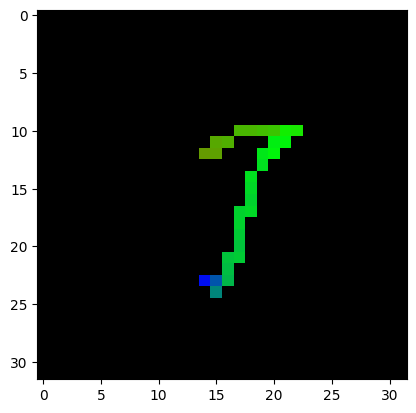

In [32]:
plt.imshow(stroke_data_uint8)

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

In [34]:
stroke_img_filename = "images/7/2.png"

In [35]:
# read the model
interpreter = tf.lite.Interpreter(model_path=model_filename)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [36]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

In [37]:
img = keras.preprocessing.image.load_img(stroke_img_filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

In [38]:
img_array = keras.preprocessing.image.img_to_array(img)
print("Shape of image_array: ",img_array.shape)
print("Type of image array: ",img_array.dtype)

Shape of image_array:  (32, 32, 3)
Type of image array:  float32


In [39]:
img_array_uint8_t = img_array.astype(np.ubyte)
img_array = img_array - 128
img_array_int8_t = img_array.astype(np.byte)

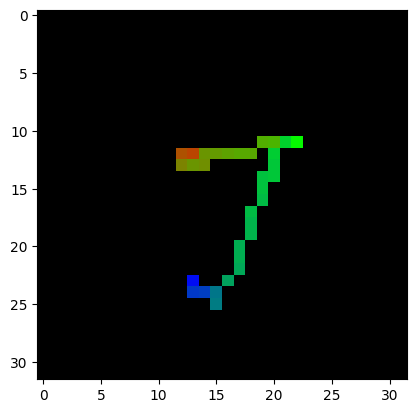

In [40]:
plt.imshow(img_array_uint8_t)

In [41]:
print("Min and max value in img array: ",np.max(img_array),np.min(img_array))

Min and max value in img array:  121.0 -128.0


In [42]:
img_array_int8_t = tf.expand_dims(img_array_int8_t, 0)  # Create batch axis

2023-12-21 15:04:49.894249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3509 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0


In [43]:
interpreter.set_tensor(input_details[0]['index'],img_array_int8_t)

In [44]:
interpreter.invoke()

In [45]:
result = interpreter.get_tensor(output_details[0]['index'])

In [46]:
print("Result of invocation: ",result)

Result of invocation:  [[-127 -128 -127 -124 -128 -128 -128  119 -128 -126]]


## Read the stroke samples for all 10 digit gestures and plot them

In [47]:
import tensorflow as tf
import tflite_runtime.interpreter as tflite
import numpy as np
import matplotlib.pyplot as plt

In [48]:
stroke_pixels = []
for i in range(10):
    f = open("test_data/{:d}.bin".format(i),"rb")
    stroke_pixels.append(np.frombuffer(f.read(),dtype=np.int8).reshape((32,32,3)))

In [49]:
print(len(stroke_pixels))

10


Now that we know how to plot a single stroke, we can extend the plot to all 10 digit strokes

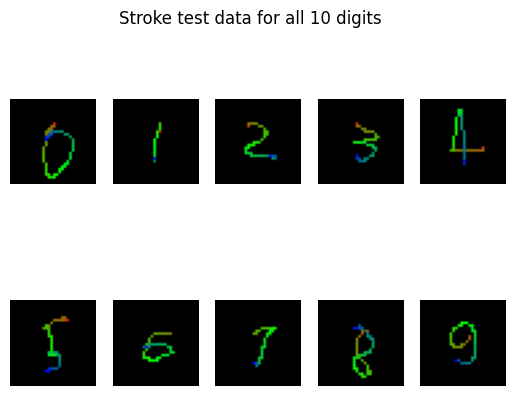

In [50]:
fig,ax = plt.subplots(2,5)
fig.suptitle("Stroke test data for all 10 digits")
for i in range(2):
    for j in range(5):
        ax[i,j].set_axis_off()
        stroke_pixels_uint8 = (stroke_pixels[i*5+j] + 128).astype(np.uint8)
        ax[i,j].imshow(stroke_pixels_uint8)

get the interpreter from the model file

In [51]:
interpreter = tflite.Interpreter(model_path="model/magic_wand_model_quant.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [52]:
print("Shape of gesture: ",stroke_pixels[0].shape)
print("dtype of gesture: ",stroke_pixels[0].dtype)
print("min: {:d}, max: {:d}".format(np.min(stroke_pixels[0]),np.max(stroke_pixels[0])))

Shape of gesture:  (32, 32, 3)
dtype of gesture:  int8
min: -128, max: 127


In [53]:
print("min: {:d}, max: {:d}".format(np.min(stroke_data),np.max(stroke_data)))
print("Shape of input tensor: ",stroke_data.shape)

min: -128, max: 117
Shape of input tensor:  (32, 32, 3)


In [59]:
for i in range(10):
    stroke_data = tf.expand_dims(stroke_pixels[i], 0)  # Create batch axis
    interpreter.set_tensor(input_details[0]['index'],stroke_data)
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]['index']).flatten()
    probabilities = (result + 128)/255
    print("Result for digit {:d}: {:d}".format(i,np.argmax(result)))
    print("Probabilities: ",end ="")
    for j in range(10):
        print("{:5.4f} ".format(probabilities[j]),end="")
    print("")            
    print(result)

Result for digit 0: 0
Probabilities: 0.7451 0.0000 0.0392 0.0000 0.0000 0.0000 0.0157 0.0039 0.1843 0.0118 
[  62 -128 -118 -128 -128 -128 -124 -127  -81 -125]
Result for digit 1: 1
Probabilities: 0.0039 0.9608 0.0078 0.0000 0.0039 0.0000 0.0078 0.0118 0.0000 0.0078 
[-127  117 -126 -128 -127 -128 -126 -125 -128 -126]
Result for digit 2: 2
Probabilities: 0.0118 0.0000 0.8078 0.1529 0.0000 0.0000 0.0196 0.0000 0.0039 0.0039 
[-125 -128   78  -89 -128 -128 -123 -128 -127 -127]
Result for digit 3: 3
Probabilities: 0.0039 0.0000 0.0510 0.9059 0.0000 0.0275 0.0078 0.0000 0.0078 0.0039 
[-127 -128 -115  103 -128 -121 -126 -128 -126 -127]
Result for digit 4: 4
Probabilities: 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 
[-128 -128 -128 -128  127 -128 -128 -128 -128 -128]
Result for digit 5: 5
Probabilities: 0.0431 0.0078 0.0784 0.2314 0.0078 0.6157 0.0157 0.0000 0.0039 0.0000 
[-117 -126 -108  -69 -126   29 -124 -128 -127 -128]
Result for digit 6: 6
Probabilities: 0.0

In [ ]:
print(result.shape)